In [1]:
#Librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import statsmodels.api as sm    
import numpy as np
from scipy.optimize import lsq_linear

# MMM Tráfico

Vamos a comenzar construyendo un modelo de regresión para estimar el tráfico físico en tienda:

$$
\text{Tráfico\_físico}_t = \beta_0 + \beta_1 \cdot \text{Tráfico\_físico}_{t-1} + \beta_2 \cdot \text{INV\_online}_t + \beta_3 \cdot \text{INV\_offline}_t + \sum_{i=4}^{n} \beta_i \cdot X_{i,t} + \varepsilon_t
$$

**Donde:**
- **$\beta_0$**: Es el intercepto del modelo (nivel base de tráfico sin inversión ni efecto del pasado).
- **$\text{Tráfico\_físico}_{t-1}$**: Valor del tráfico físico en tienda del mes anterior (*delay*).
- **$\text{INV\_online}_t$**: Inversión publicitaria en medios digitales en el mes actual.
- **$\text{INV\_offline}_t$**: Inversión publicitaria en medios tradicionales en el mes actual.
- **$\sum_{i=4}^{n} \beta_i \cdot X_{i,t}$**: Variables exógenas que pueden influir en el tráfico, como:
  - Tráfico web total
  - Días festivos o fines de semana
  - Eventos comerciales (Black Friday, rebajas, etc.)
- **$\varepsilon_t$**: Término de error del modelo, que recoge la variabilidad no explicada por las variables anteriores.

## Tabla Final

A continuación cargamos todas las tablas que vamos a emplear para el modelo de atribución:

In [2]:
df_web = pd.read_csv("../data/raw/web.csv", sep=",")
df_offline = pd.read_csv("../data/raw/offline.csv", sep=",")
df_time = pd.read_csv("../data/raw/time.csv", sep=",")
df_visit = pd.read_csv("../data/raw/visit.csv", sep=",")
df_inv = pd.read_csv("../data/raw/inv.csv", sep=",")

Tenemos que añadir los sufijos web y offline a las columans de estas tablas ya que sus nombre coinciden y posteriormente al hacer el merge necesitamos distinguirlas.

In [3]:
df_offline = df_offline.rename(columns={
    col: f"{col}_off" for col in df_offline.columns if col != "ID_Date"})


df_visit = df_visit.rename(columns={
    col: f"{col}_visit" for col in df_visit.columns if col != "ID_Date"})


**Tabla Inversión**

Se han generado las siguientes métricas a partir de la tabla de inversión mensual(de cara a facilitar la evaluación del budget):

- `Pct_Online`: porcentaje de la inversión total del mes destinada a medios online.
- `Pct_Offline`: porcentaje de la inversión total del mes destinada a medios offline.


In [4]:
inversion_online = df_inv['INTERNET'] + df_inv['PlataformasVideo']+df_inv['PRODUCCION'] + df_inv['VARIOS']

inversion_offline = (df_inv['CINE'] + df_inv['EXTERIOR'] + df_inv['PRENSA'] +
                    df_inv['RADIO'] + df_inv['REVISTAS']+df_inv['PRODUCCION'] + df_inv['VARIOS'])

df_inv['Inversion_Online'] = inversion_online
df_inv['Inversion_Offline'] = inversion_offline

In [5]:
df_inv.head()

,ID_Date,CINE,EXTERIOR,INTERNET,PRENSA,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS,INV_Total,Inversion_Online,Inversion_Offline
0,202201,59887.84,8200.00,133666.43,0.0,6050.0,2426.40,18013.50,338824.94,7531.03,574600.14,486072.40,102108.77
1,202202,72291.56,94627.51,189275.94,10000.0,6700.0,0.00,49110.91,487537.14,6972.02,916515.08,690485.10,239702.00
2,202203,55000.00,0.00,214037.62,4500.0,3700.0,0.00,0.00,75000.00,15284.85,367522.47,308022.47,78484.85
3,202204,10883.30,0.00,194816.97,48800.0,21550.0,1140.00,40876.00,610865.89,12255.75,941187.91,839488.61,135505.05
4,202205,74333.20,0.00,130795.16,11000.0,4900.0,102851.86,20775.75,393807.74,7926.46,746390.17,537429.36,221787.27


**Merge para Tabla Final**

In [6]:
# Union todas las tablas por PK=ID_date
df_merge = df_inv.merge(df_web, on='ID_Date')
df_merge = df_merge.merge(df_offline, on='ID_Date')
df_merge = df_merge.merge(df_time, on='ID_Date')
df_merge = df_merge.merge(df_visit, on='ID_Date')
df_merge = df_merge.sort_values('ID_Date')

# Delay de compras
df_merge['Sales_1_ago'] = df_merge['Sales_off'].shift(1) # 1 mes atras
df_merge['Sales_2_ago'] = df_merge['Sales_off'].shift(2) # 2 meses atras
# Delay Tráfico
df_merge['Visit_Store_1_ago']=df_merge['Visit_Store_off'].shift(1)
df_merge['Visit_Store_2_ago']=df_merge['Visit_Store_off'].shift(1)
# Variables Pasadas
df_merge['Unique_visitors_1_ago']=df_merge['Unique_visitors'].shift(1)

*Nota*:Para los primeros dos meses deconcoemos los visitantes previos pero los dejamos como NaN para que lo gestione el modelo.

In [7]:
df_merge.head()

,ID_Date,CINE,EXTERIOR,INTERNET,PRENSA,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS,...,Zapatos_visit,Home_visit,Interior_visit,Otros_visit,SR_Total_visit,Sales_1_ago,Sales_2_ago,Visit_Store_1_ago,Visit_Store_2_ago,Unique_visitors_1_ago
0,202201,59887.84,8200.00,133666.43,0.0,6050.0,2426.40,18013.50,338824.94,7531.03,...,36790,18848,9906,183,213346,NaN,NaN,NaN,NaN,NaN
1,202202,72291.56,94627.51,189275.94,10000.0,6700.0,0.00,49110.91,487537.14,6972.02,...,37960,20047,11057,461,299630,1299.0,NaN,5516.0,5516.0,272382.0
2,202203,55000.00,0.00,214037.62,4500.0,3700.0,0.00,0.00,75000.00,15284.85,...,37765,20105,66200,198,259923,1752.0,1299.0,6769.0,6769.0,352581.0
3,202204,10883.30,0.00,194816.97,48800.0,21550.0,1140.00,40876.00,610865.89,12255.75,...,76244,17629,17827,176,242206,1897.0,1752.0,6249.0,6249.0,332955.0
4,202205,74333.20,0.00,130795.16,11000.0,4900.0,102851.86,20775.75,393807.74,7926.46,...,79434,18526,10738,186,212188,1546.0,1897.0,6507.0,6507.0,282169.0


In [8]:
# Guardar el DataFrame en un archivo CSV en la carpeta 'data'
nombre_archivo = "../data/merge.csv"  # Cambia 'tu_archivo.csv' por el nombre que desees
df_merge.to_csv(nombre_archivo, index=False)

## Correlaciones Tráfico físico

A continuación ,antes de ajustar la regresión vamos a estudiar qué variables exógenas podíamos incluir por tabla:
- `Inv`    (no la tenemos en cuenta porque ya lo estamos metiendo con el presupuesto)
- `Offline` (cómo afectan variables como ticket medio/mercado a las ventas)
- `Time `   (cómo afectan distintos periodos de tiempo a las compras)
- `Visit` (dentro de la web cómo afectan las visitas a la disitntas páginas sobre las compras)
- `Web `   (cómo afectan las visitas a la web sobre las compras en tienda)

### Tabla Time

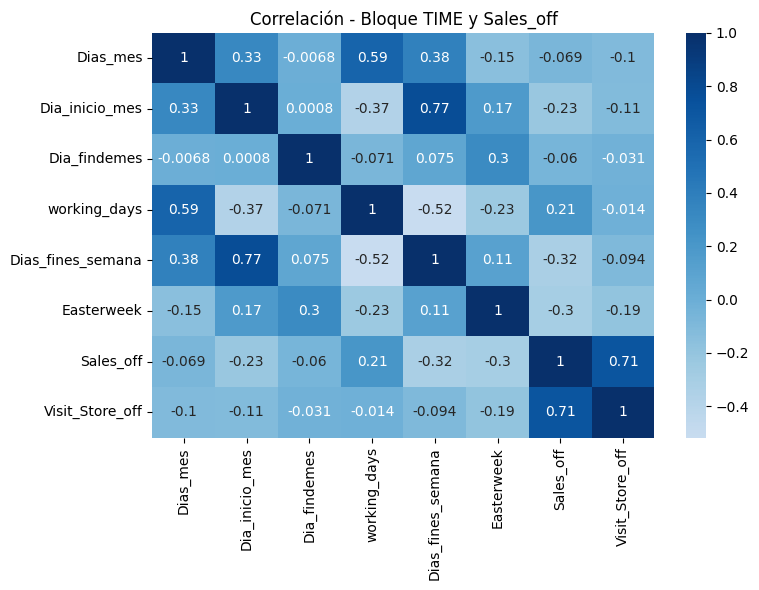

In [9]:
cols_time = ['Dias_mes', 'Dia_inicio_mes', 'Dia_findemes', 'working_days', 'Dias_fines_semana', 'Easterweek' ,'Sales_off','Visit_Store_off']

df_time_corr = df_merge[cols_time]
corr_time = df_time_corr.corr(numeric_only=True)


plt.figure(figsize=(8, 6))
sns.heatmap(corr_time, annot=True, cmap='Blues', center=0)
plt.title("Correlación - Bloque TIME y Sales_off")
plt.tight_layout()
plt.show()


**Variables Más Correlacionadas en Time con Visitantes en Tienda**

*Comportamiento de los Compradores*
1. En semana santa tanto el tráfico como las ventas dismuyen.

2. A medida que aumenta en número de días en fin de semana:
    - Ventas:dismuyen en gran medida
    - Visitas:baja de forma no muy significativa el número de visitantes.

In [10]:
df_merge.groupby('Easterweek')[['Sales_off','Visit_Store_off']].mean()


,Sales_off,Visit_Store_off
Easterweek,,
0,1762.272727,6147.272727
1,1451.333333,5710.000000


In [11]:
df_merge.groupby('Dias_mes')[['Sales_off','Visit_Store_off']].mean()

,Sales_off,Visit_Store_off
Dias_mes,,
28,1874.000000,6437.666667
30,1684.833333,6038.166667
31,1746.142857,6105.666667


### Tabla Inv

Aunque incialmente agrupamos la inversión en medios offline y online, hemos decicido analizar más fondo la relación de la publidad en cada medio con las ventas y tráfico.

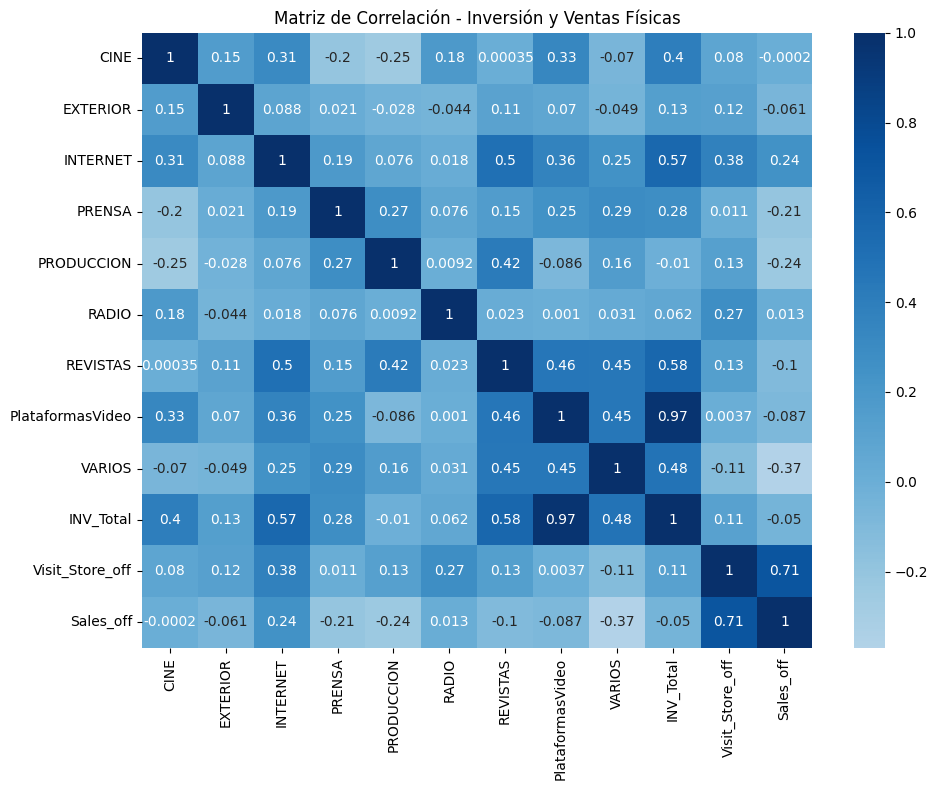

In [12]:
cols_inv = [
    'CINE', 'EXTERIOR', 'INTERNET', 'PRENSA', 'PRODUCCION',
    'RADIO', 'REVISTAS', 'PlataformasVideo', 'VARIOS',
    'INV_Total','Visit_Store_off','Sales_off'
]


df_inv_corr = df_merge[cols_inv]
corr_inv = df_inv_corr.corr(numeric_only=True)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_inv, annot=True, cmap='Blues', center=0)
plt.title("Matriz de Correlación - Inversión y Ventas Físicas")
plt.tight_layout()
plt.show()

**Recomendación clave**

De cara a la optimización del ratio ventas / tráfico, la empresa debería priorizar la inversión en **medios que impulsen ambos objetivos** a la vez.

Solo el canal **INTERNET** muestra una correlación positiva significativa tanto con las ventas físicas como con el tráfico en tienda, por lo que es el **medio más eficiente** para mejorar el rendimiento global de las campañas.

El resto de canales muestran impacto muy bajo o desequilibrado, por lo que su aportación al ratio es limitada.

### Tabla Web

**Variables más optimizan el Ratio**

-  **DirectTraffic**               
- **Product_configurator_Visists**
- **PDFBrochuresDownloaded**      


Resultan especialmente **interesantes para la empresa a la hora de optimizar su ratio ventas/tráfico**.

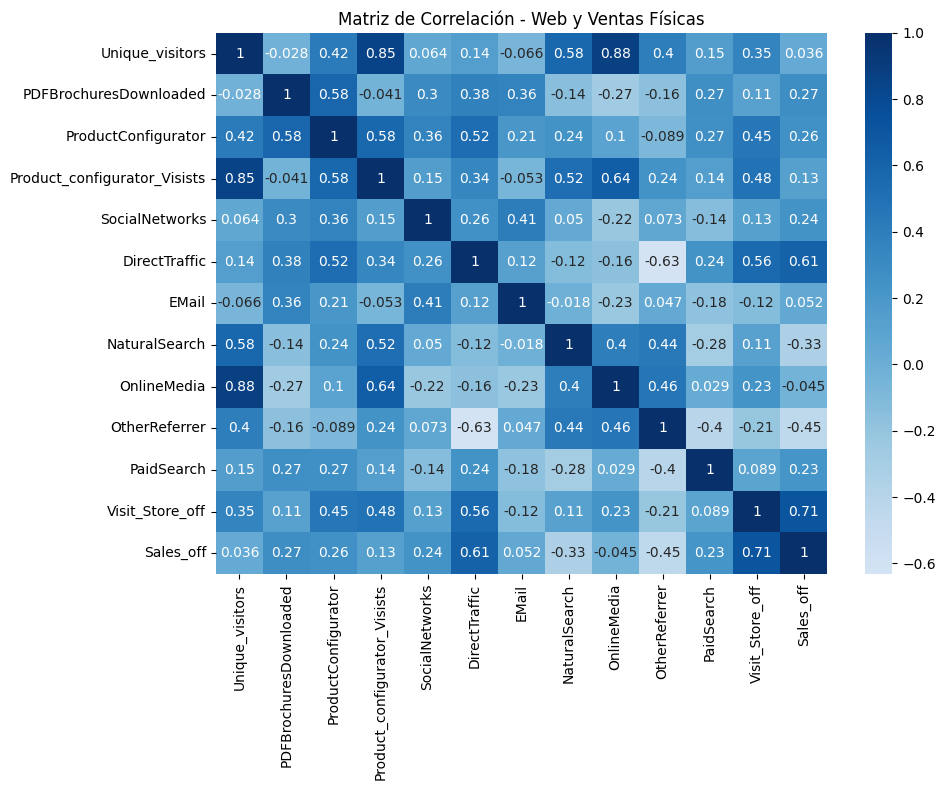

In [13]:
cols_web = [
    'Unique_visitors', 'PDFBrochuresDownloaded', 'ProductConfigurator',
    'Product_configurator_Visists', 'SocialNetworks', 'DirectTraffic',
    'EMail', 'NaturalSearch', 'OnlineMedia', 'OtherReferrer', 'PaidSearch','Visit_Store_off',
    'Sales_off'
]


df_web_corr = df_merge[cols_web]
corr_web = df_web_corr.corr(numeric_only=True)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_web, annot=True, cmap='Blues', center=0)
plt.title("Matriz de Correlación - Web y Ventas Físicas")
plt.tight_layout()
plt.show()



**Variables + Correlacionadas Sales**

- **DirectTraffic** → 0.61
- **PDFBrochuresDownloaded** → 0.27
- **ProductConfigurator** → 0.26
- **SocialNetworks** → 0.24


**Variables + Correlacionadas Visits**

Correlación Positva:
- **DirectTraffic** → 0.56
- **Product_configurator_Visists** → 0.48
- **Unique_visitors** → 0.35
- **OnlineMedia** → 0.23

Correlación Negativa:
**OtherReferrer** → -0.45

### Tabla Offline

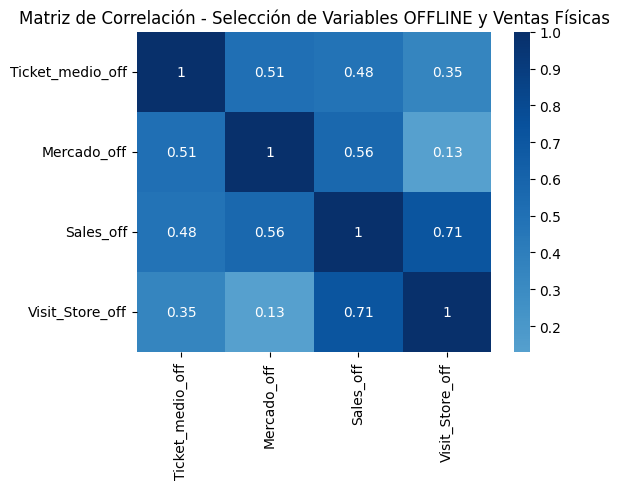

In [14]:
# Solo seleccionamos Ticket_Medio y Mercado porque el resto están correlacionadas con Sales
cols_selected = [ 'Ticket_medio_off', 'Mercado_off','Sales_off','Visit_Store_off']

df_selected_corr = df_merge[cols_selected]
corr_selected = df_selected_corr.corr(numeric_only=True)


plt.figure(figsize=(6, 5))
sns.heatmap(corr_selected, annot=True, cmap='Blues', center=0)
plt.title("Matriz de Correlación - Selección de Variables OFFLINE y Ventas Físicas")
plt.tight_layout()
plt.show()


**Variables de Offline más correlacionadas con Tráfico y Ventas**

 Variable             | Sales_off | Visit_Store_off |
|----------------------|------------------------------|------------------------------------|
| **Mercado_off**      | 0.56                         | 0.13                               |
| **Ticket_medio_off** | 0.48                         | 0.35                               |

*Conclusiones*
- **Mercado_off**: No aumenta el tráfico, pero sí las ventas.  
   Indica que al dominar el mercado, **mejora la conversión**: más compradores entre los visitantes.

- **Ticket_medio_off**: Cuando el cliente gasta más, **suben tanto las visitas como las ventas**.  
   Refleja campañas o momentos de mayor intención de compra.

##  MMM Tráfico

**Objetivo:**
Predecir cuántas personas visitan las tiendas físicas en un mes, en función de la inversión publicitaria y del calendario.

**Fórmula:**

$
\text{Visit\_Store\_off}_t = \beta_0 + \beta_1 \cdot \text{Visit\_Store\_off}_{t-1} + \beta_2 \cdot \text{INV\_online}_t + \beta_3 \cdot \text{INV\_offline}_t + \sum_{i} \beta_i \cdot \text{Calendario}_{i,t} + \varepsilon_t
$

- `Visit_Store_off_{t-1}`: tráfico físico del mes anterior.  
- `INV_online_t`, `INV_offline_t`: inversión en medios digitales y tradicionales.  
- `Calendario_{i,t}`: variables como días laborables, fines de semana, eventos, etc.



In [15]:
variables = [
    'Visit_Store_1_ago',       # Delay
    'Inversion_Online','Inversion_Offline', # Budget
    'DirectTraffic','Unique_visitors','Unique_visitors_1_ago' , # Tráfico Web
    'Dias_mes','Easterweek' # Exógenas
            
]
# Variable objetivo
objetivo = 'Visit_Store_off'


df_modelo = df_merge[[objetivo] + variables].dropna()

# X e y
X = df_modelo[variables]
y = df_modelo[objetivo]

# Cte
X = sm.add_constant(X)

modelo = sm.OLS(y, X).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:        Visit_Store_off   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     5.001
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           0.000789
Time:                        15:38:27   Log-Likelihood:                -259.92
No. Observations:                  35   AIC:                             537.8
Df Residuals:                      26   BIC:                             551.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   991.93

### Coeficientes tráfico

Durante el ajuste inicial, el coeficiente de `Inversion_Online` resultó **negativo**, lo cual es **incoherente** con la lógica del modelo (una mayor inversión debería aumentar el tráfico).

Para corregirlo, se impuso un límite inferior positivo en ese coeficiente (`≥ 0`). Esta restricción obligó al modelo a **ajustar el intercepto**, lo que **modifica ligeramente la línea base del problema**, pero **sin afectar significativamente el poder explicativo del modelo (R²)**.

Este ajuste mantiene la coherencia económica y permite una interpretación más realista del impacto de la inversión online sobre el tráfico físico.

In [16]:

# Variables
variables = [
    'Visit_Store_1_ago',        # delay        
    'Inversion_Online',         # presupuesto online (forzado ≥ 0)
    'Inversion_Offline',        # presupuesto offline (forzado ≥ 0)
    'Dias_mes',                 # exógenas
    'Easterweek',
    'Unique_visitors',
    'Unique_visitors_1_ago',
    'DirectTraffic'
]
objetivo = 'Visit_Store_off'

# Crear X e y
df_modelo = df_merge[[objetivo] + variables].dropna()
X = df_modelo[variables].values
y = df_modelo[objetivo].values


X = np.column_stack([np.ones(X.shape[0]), X])  # columna de 1s
columnas = ['const'] + variables


n_vars = X.shape[1]
lb = np.full(n_vars, -np.inf)
ub = np.full(n_vars, np.inf)


lb[2] = 0.0001  # Inversion_Online
lb[3] = 0  # Inversion_Offline


resultado = lsq_linear(X, y, bounds=(lb, ub))


for var, coef in zip(columnas, resultado.x):
    print(f"{var}: {coef:.4f}")

# R² manualmente
y_pred = X @ resultado.x
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2 = 1 - ss_res / ss_tot
print(f"\nR² (con restricciones): {r2:.1f}")

const: 899.7103
Visit_Store_1_ago: -0.2422
Inversion_Online: 0.0001
Inversion_Offline: 0.0061
Dias_mes: 103.3063
Easterweek: -389.9477
Unique_visitors: -0.0026
Unique_visitors_1_ago: 0.0070
DirectTraffic: 0.0214

R² (con restricciones): 0.6


In [17]:
coef_trafico_df = pd.DataFrame({
    "variable": columnas,        
    "coef": resultado.x          
})

coef_trafico_df.to_csv("../data/coef/coef_trafico.csv", index=False)

## MMM sales

**Dinámica:**
Las **ventas en tienda** (`Sales_off`) dependen directamente del **tráfico físico estimado** (`Visit_Store_off`), porque **sin tráfico no hay posibilidad de conversión**. Es decir, el modelo busca explicar cuántas ventas se generan en función de cuántas personas llegan a la tienda, considerando además factores de calendario e inversión adicional que puedan influir en la conversión.


**Fórmula:**

$
\text{Sales\_off}_t = \alpha_0 + \alpha_1 \cdot \text{Sales}_{t-1} + \alpha_2 \cdot \text{Visit\_Store\_off}_t + \sum_{j} \alpha_j \cdot \text{Factores}_{j,t} + \varepsilon_t
$

- `Sales_{t-1}`: ventas del mes anterior (efecto de arrastre).
- `Visit_Store_off_t`: tráfico estimado del modelo anterior.
- `Factores_{j,t}`: variables como días hábiles, fines de semana, inicio de mes, inversión offline directa

In [18]:
variables = [
    'Sales_1_ago',
    'Visit_Store_off',
    'working_days','Dias_fines_semana','Dia_inicio_mes',  
    'Mercado_off'        
]

# Variable objetivo
objetivo = 'Sales_off'


df_modelo = df_merge[[objetivo] + variables].dropna()
X = df_modelo[variables]
y = df_modelo[objetivo]

# Cte
X = sm.add_constant(X)


modelo = sm.OLS(y, X).fit()
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:              Sales_off   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     16.52
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           4.80e-08
Time:                        15:38:27   Log-Likelihood:                -220.91
No. Observations:                  35   AIC:                             455.8
Df Residuals:                      28   BIC:                             466.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -357.8618    984.44

In [19]:
coef_ventas_df = pd.DataFrame({
    "variable": modelo.params.index,
    "coef": modelo.params.values
})
coef_ventas_df.to_csv("../data/coef/coef_ventas.csv", index=False)